In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 300
})



from Finite_volume_method_1D import *

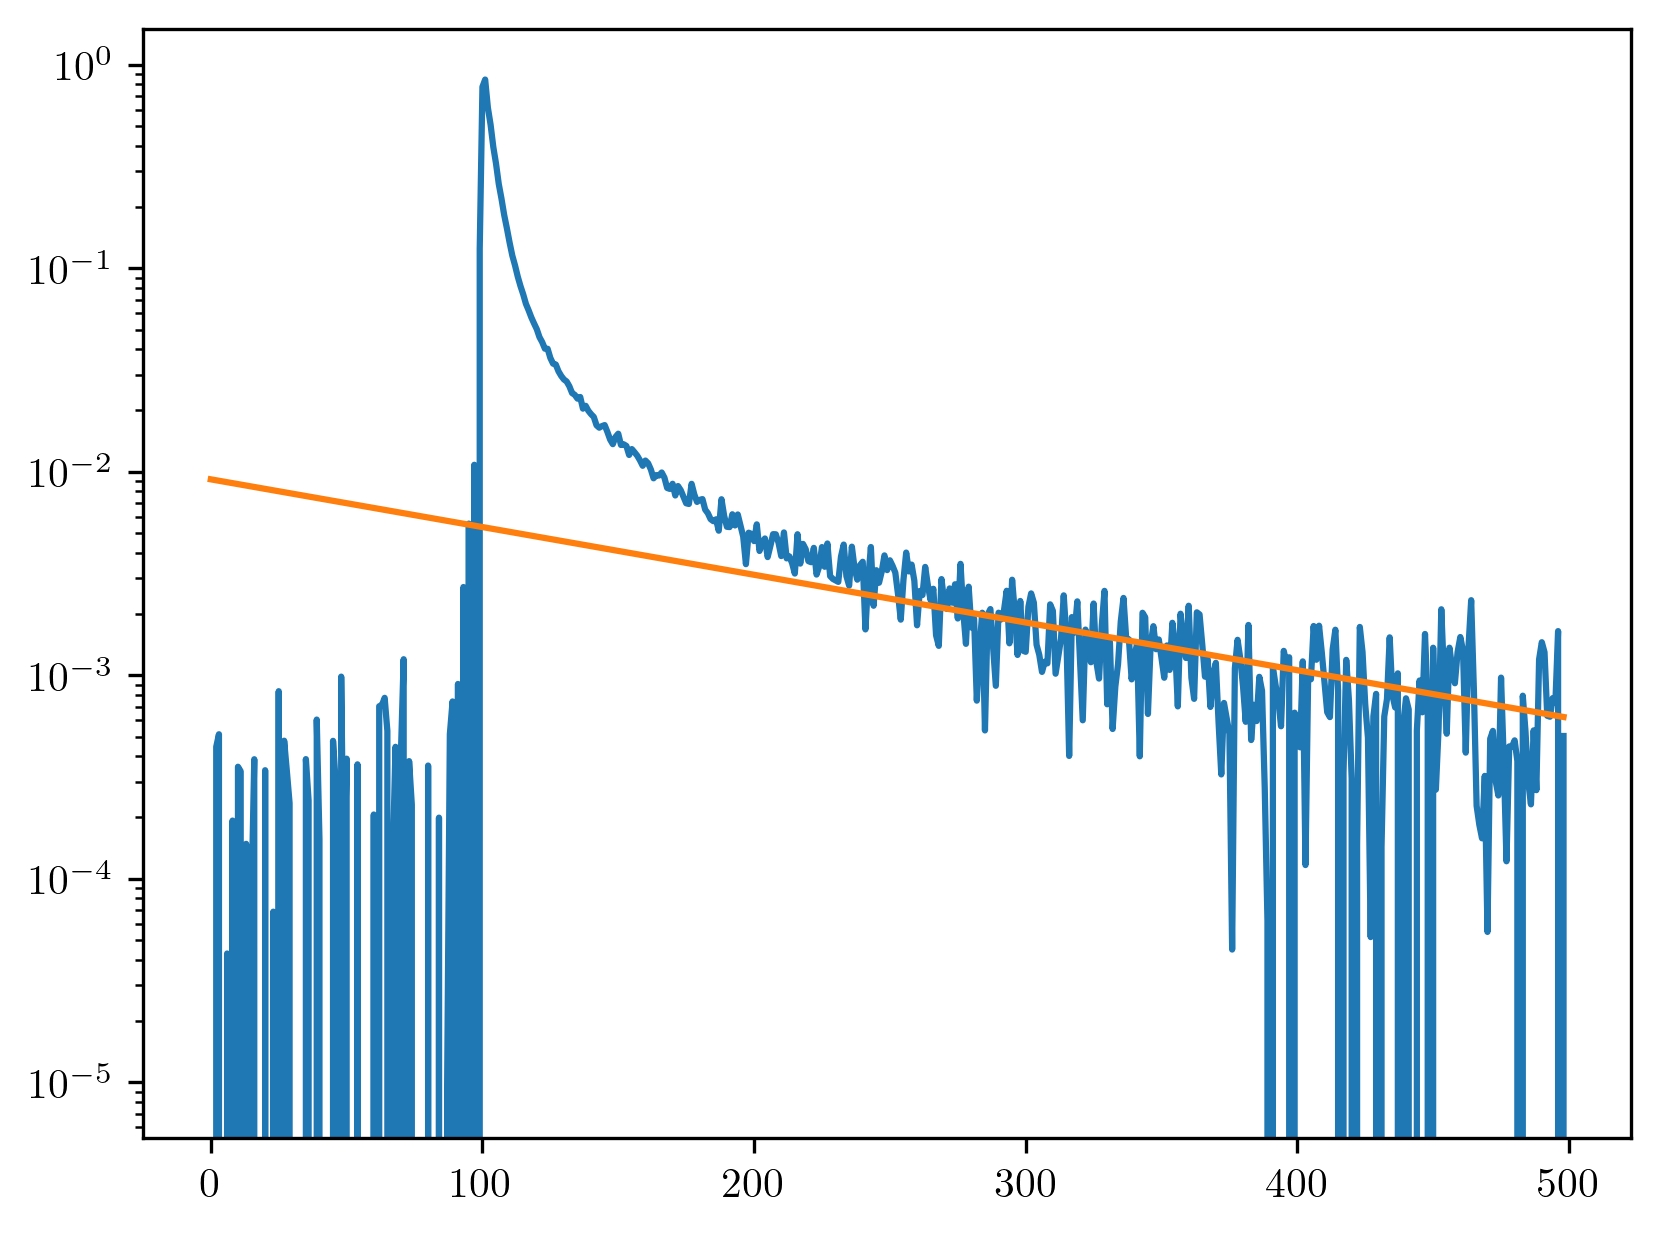

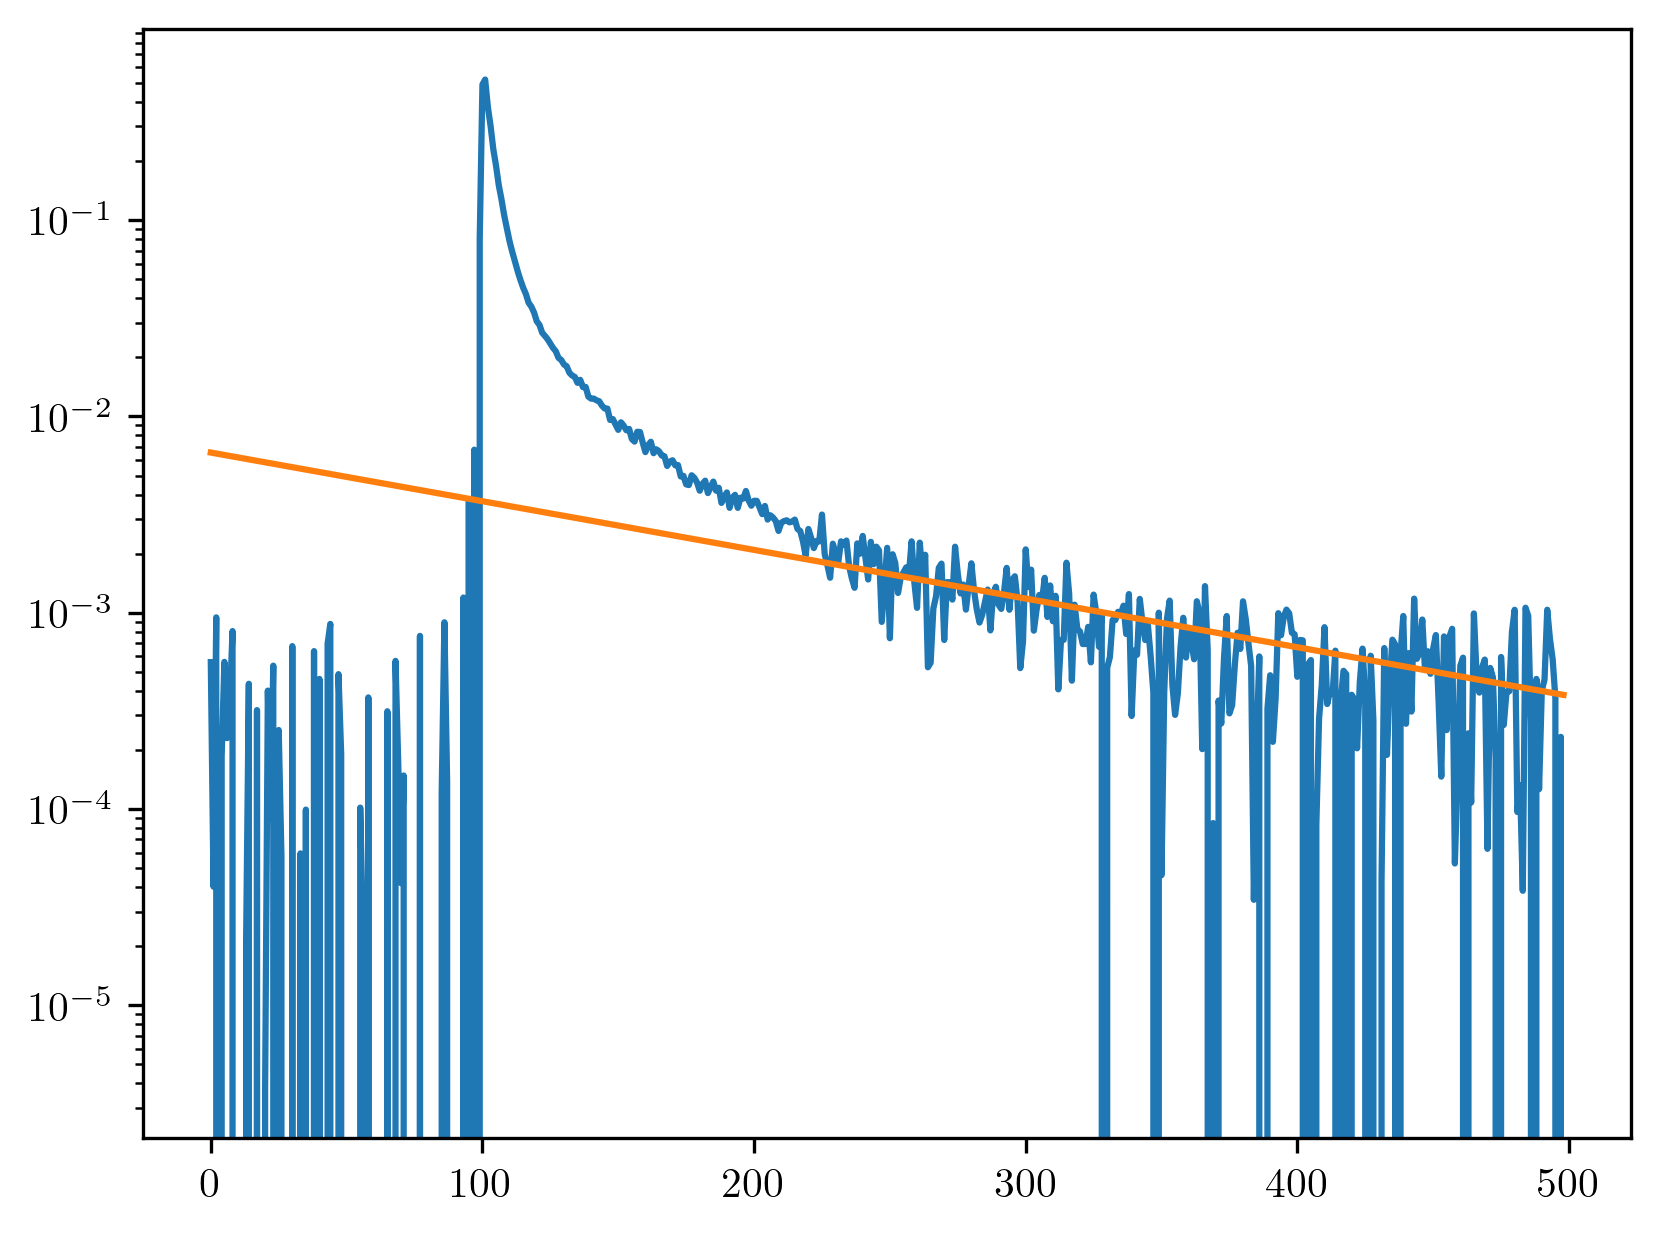

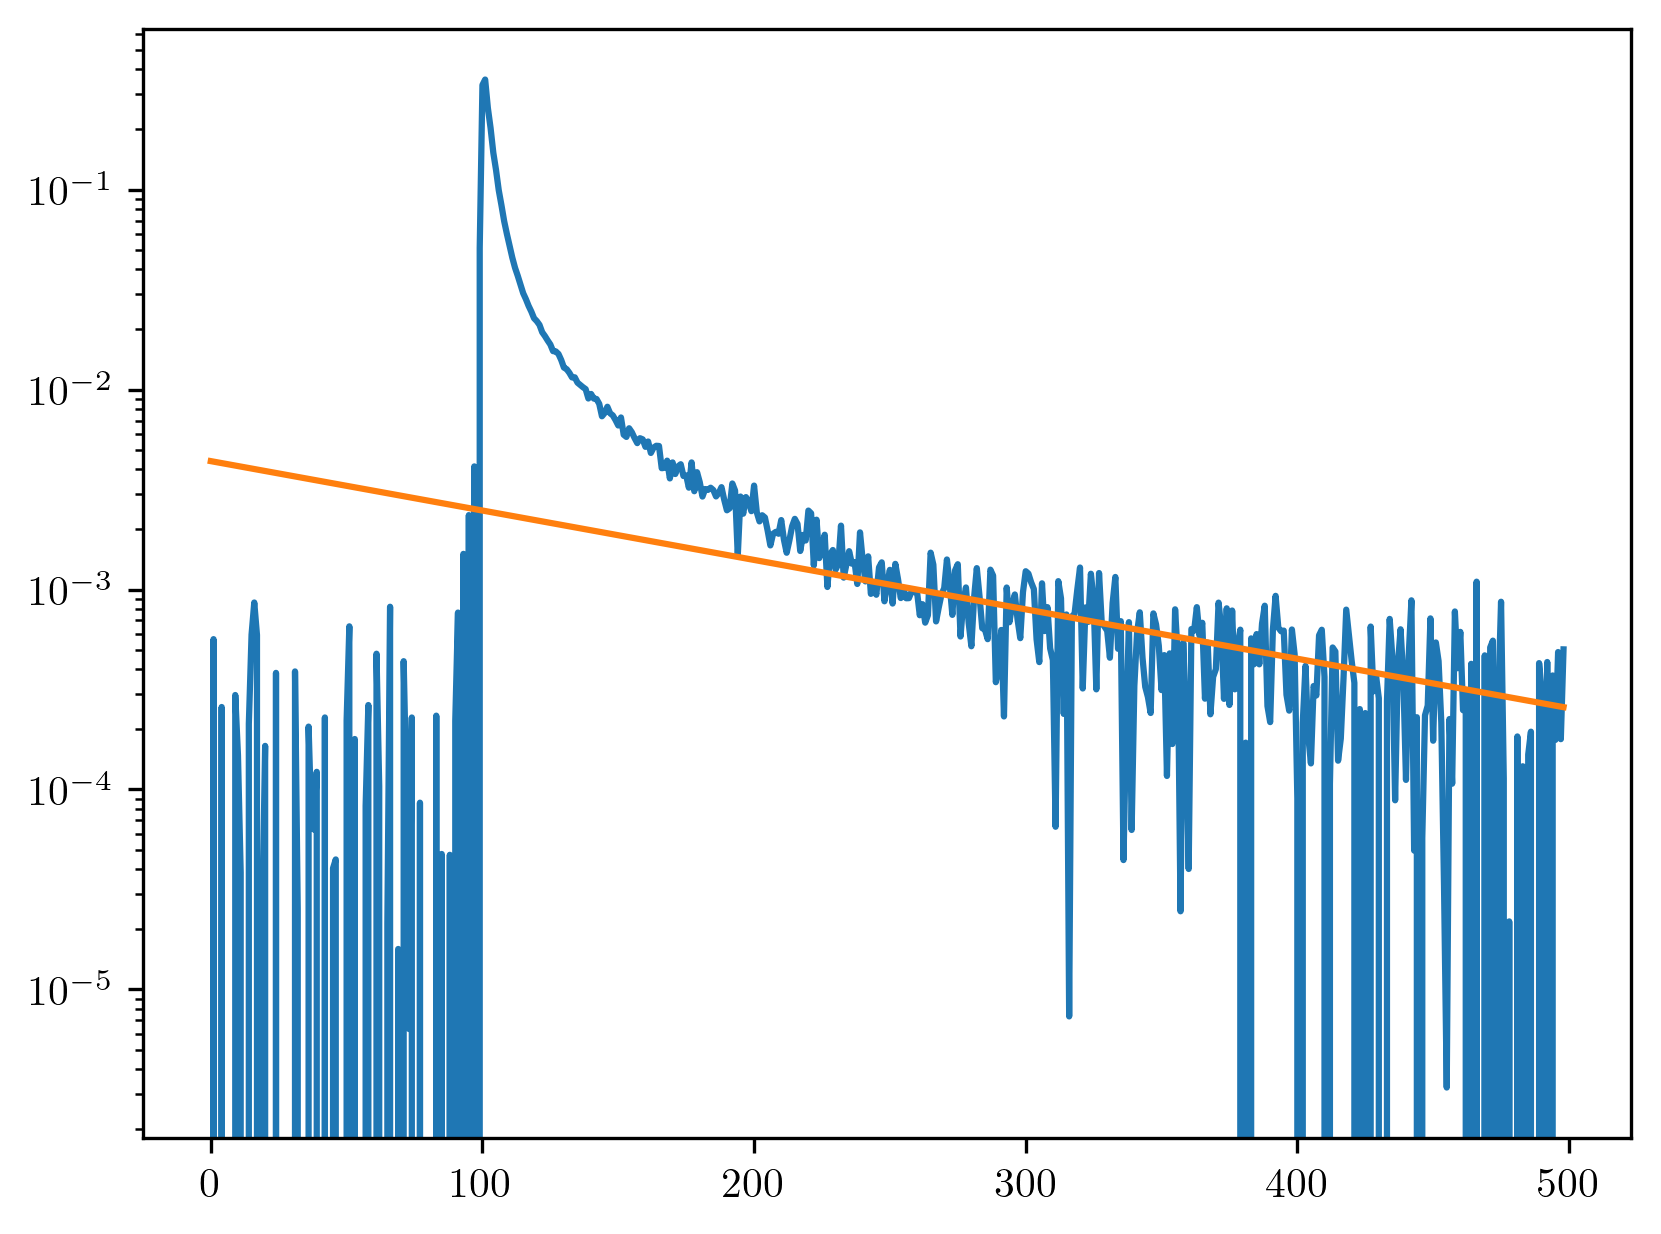

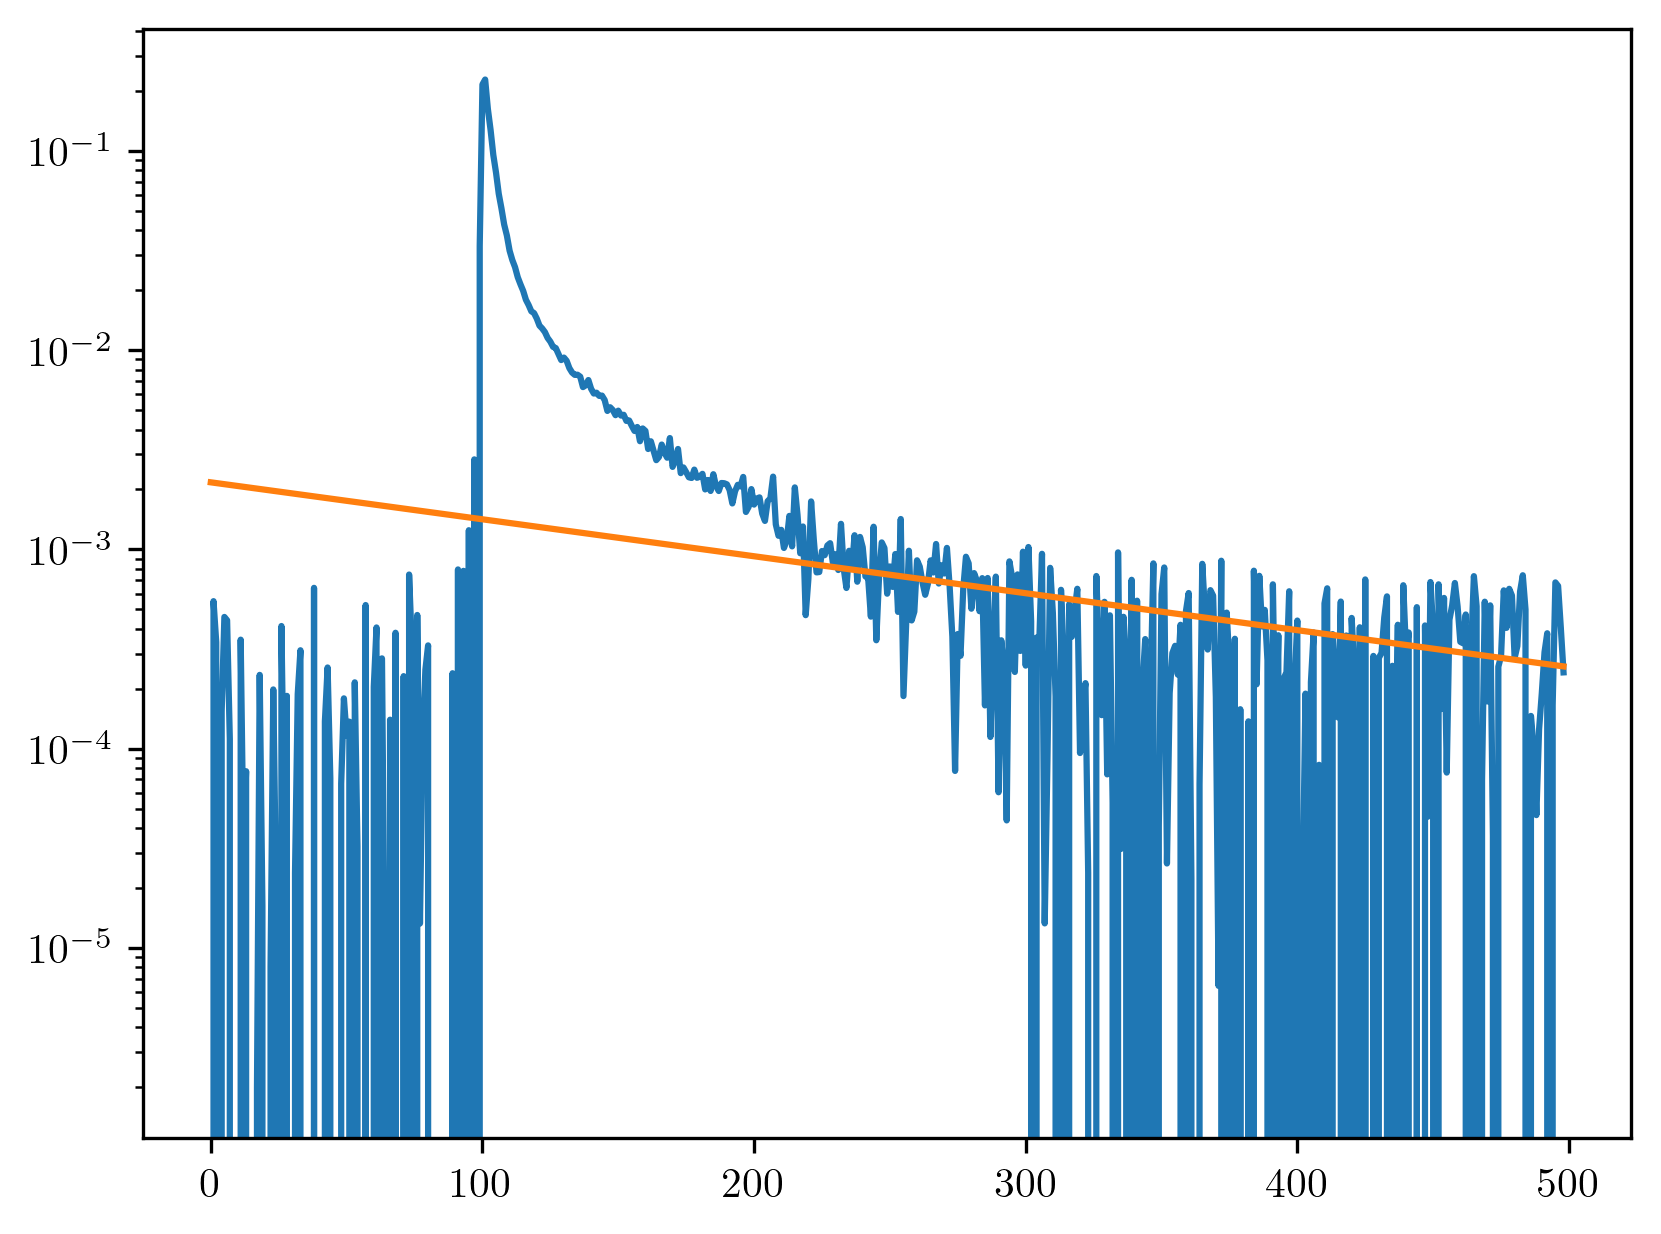

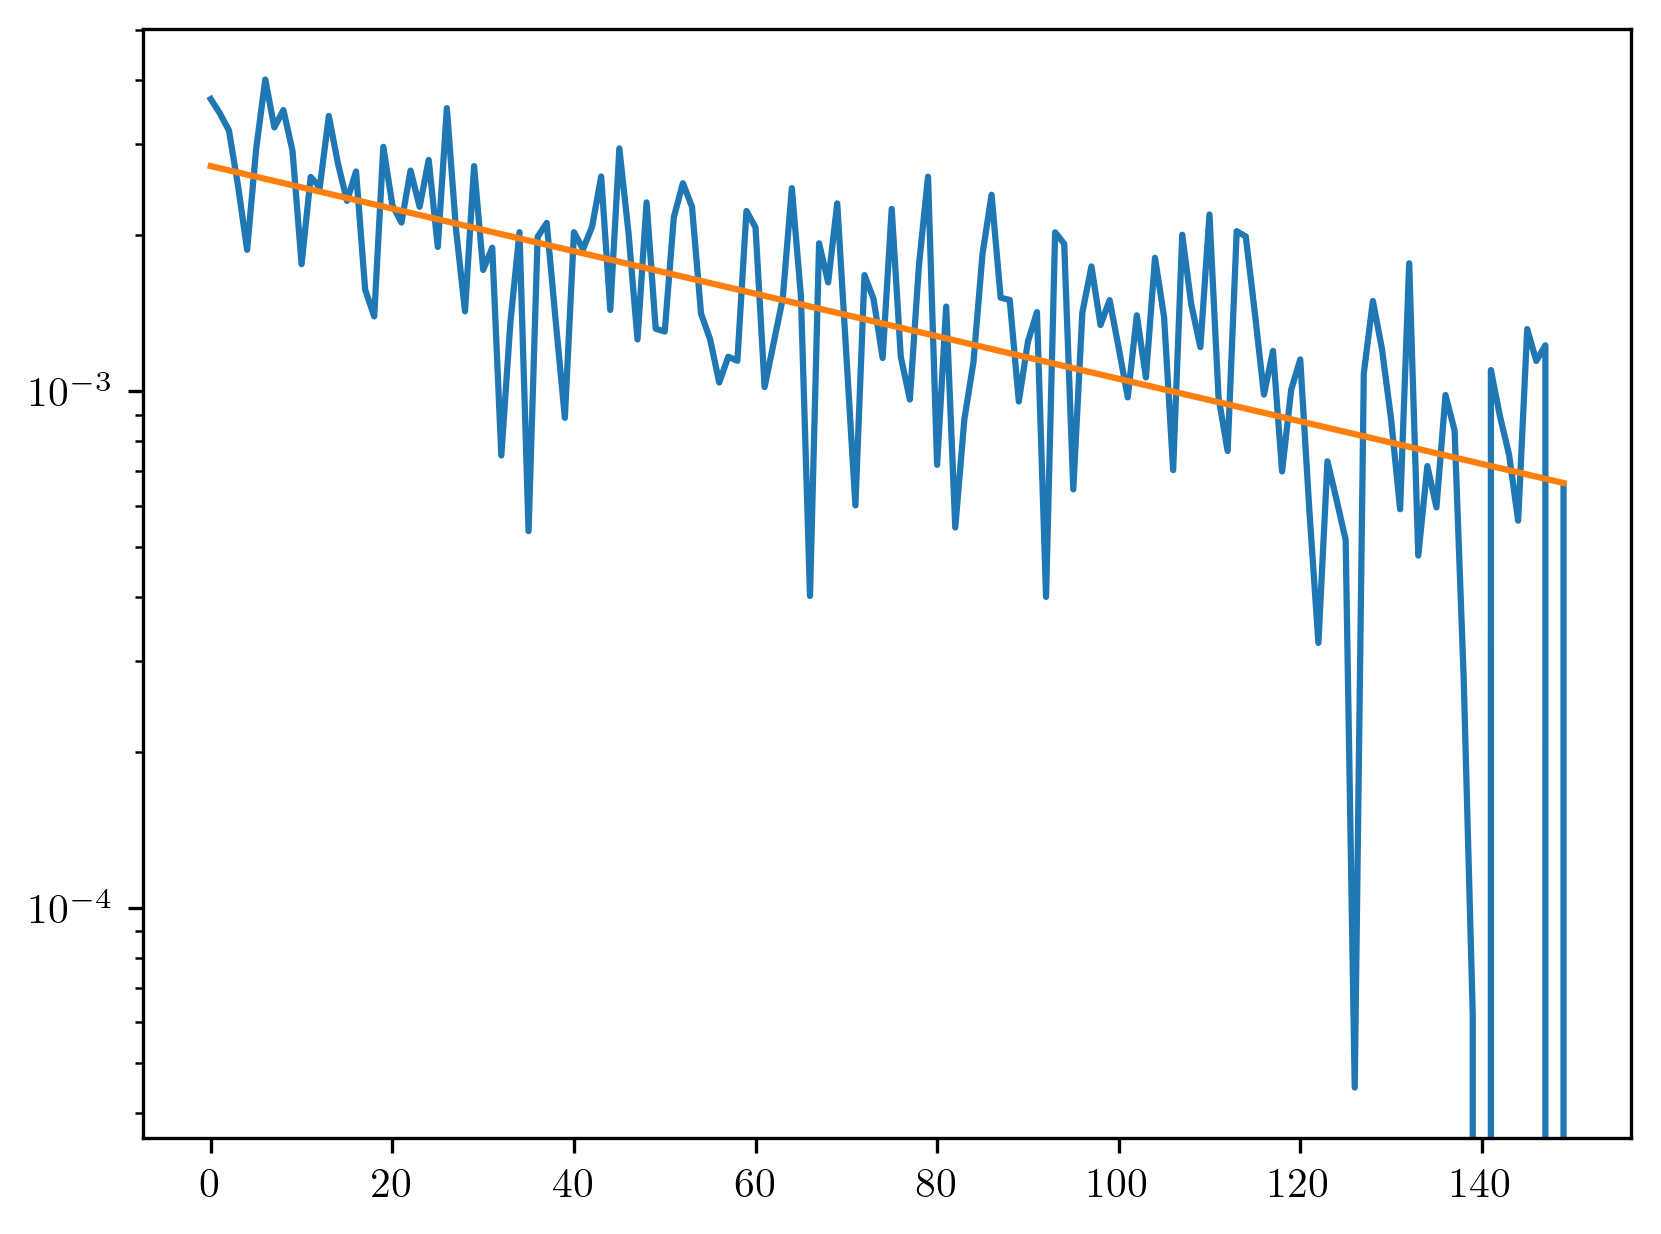

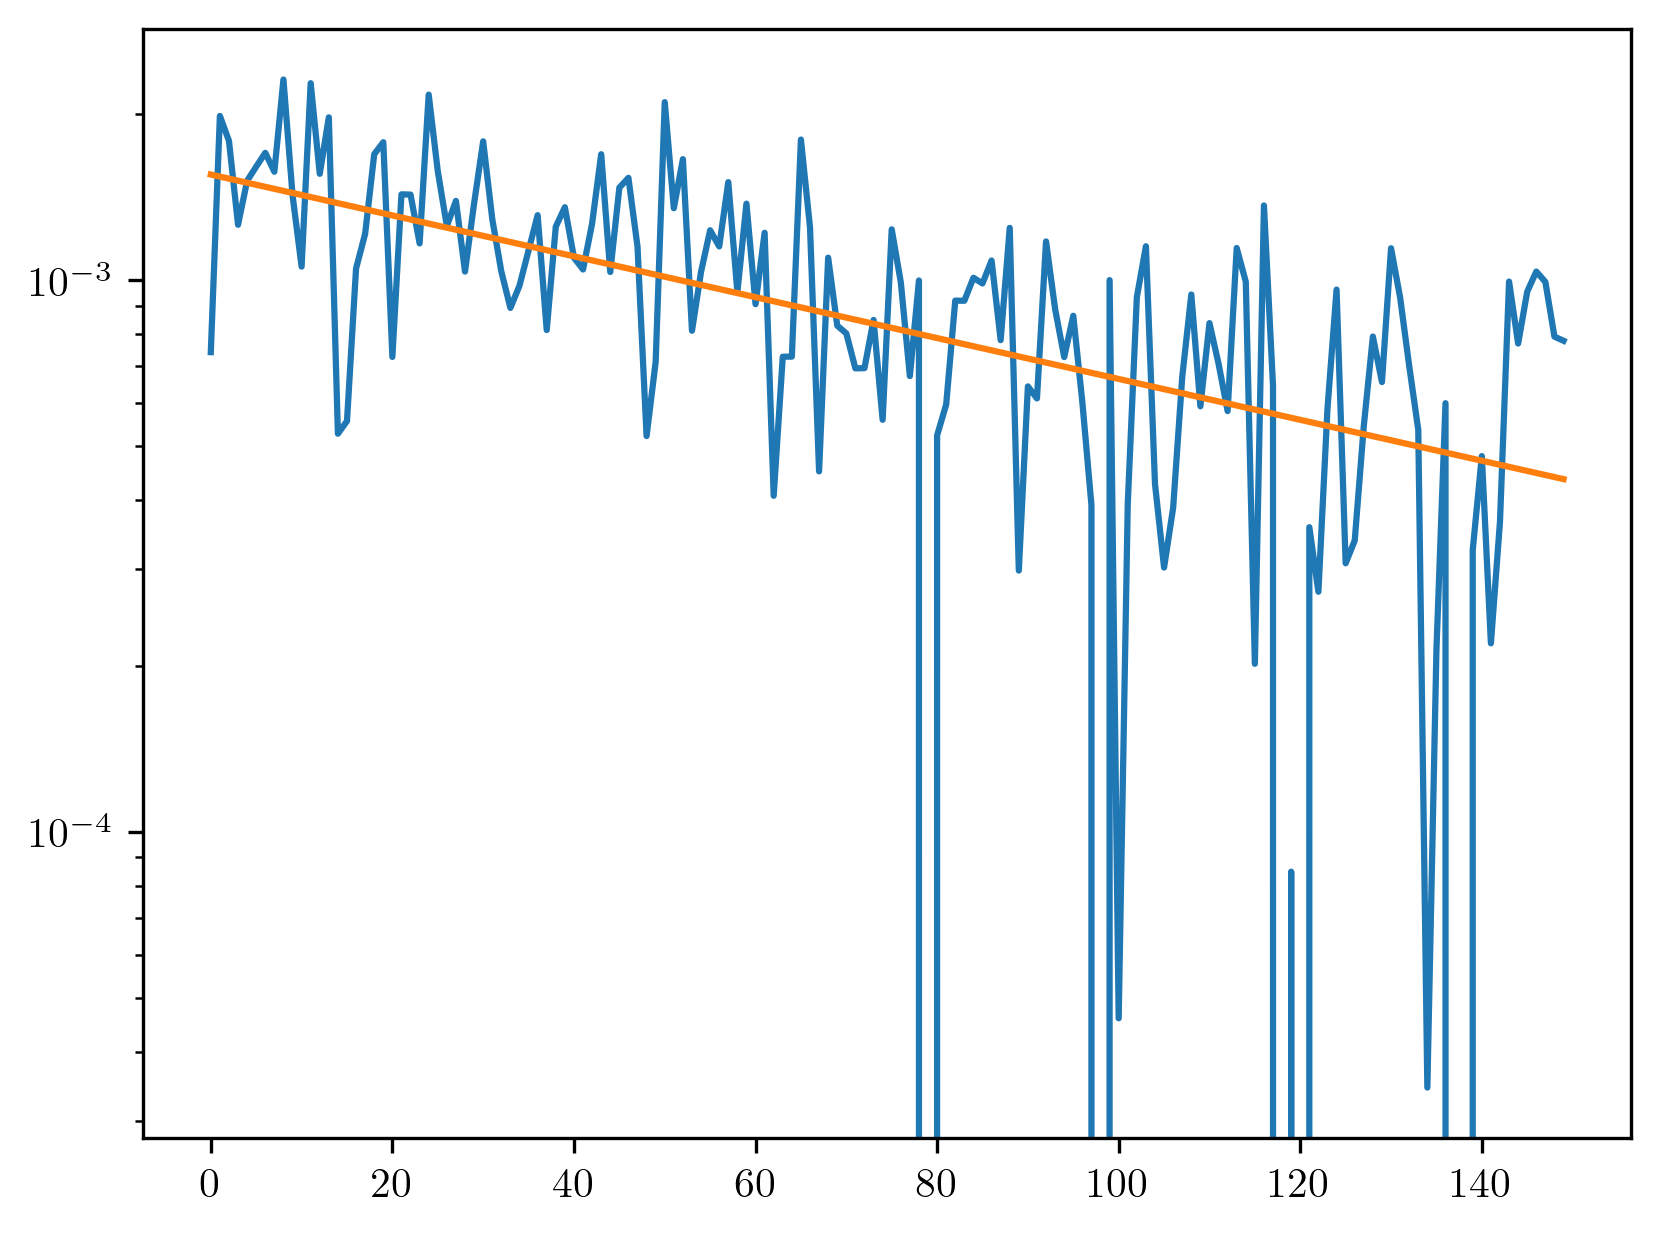

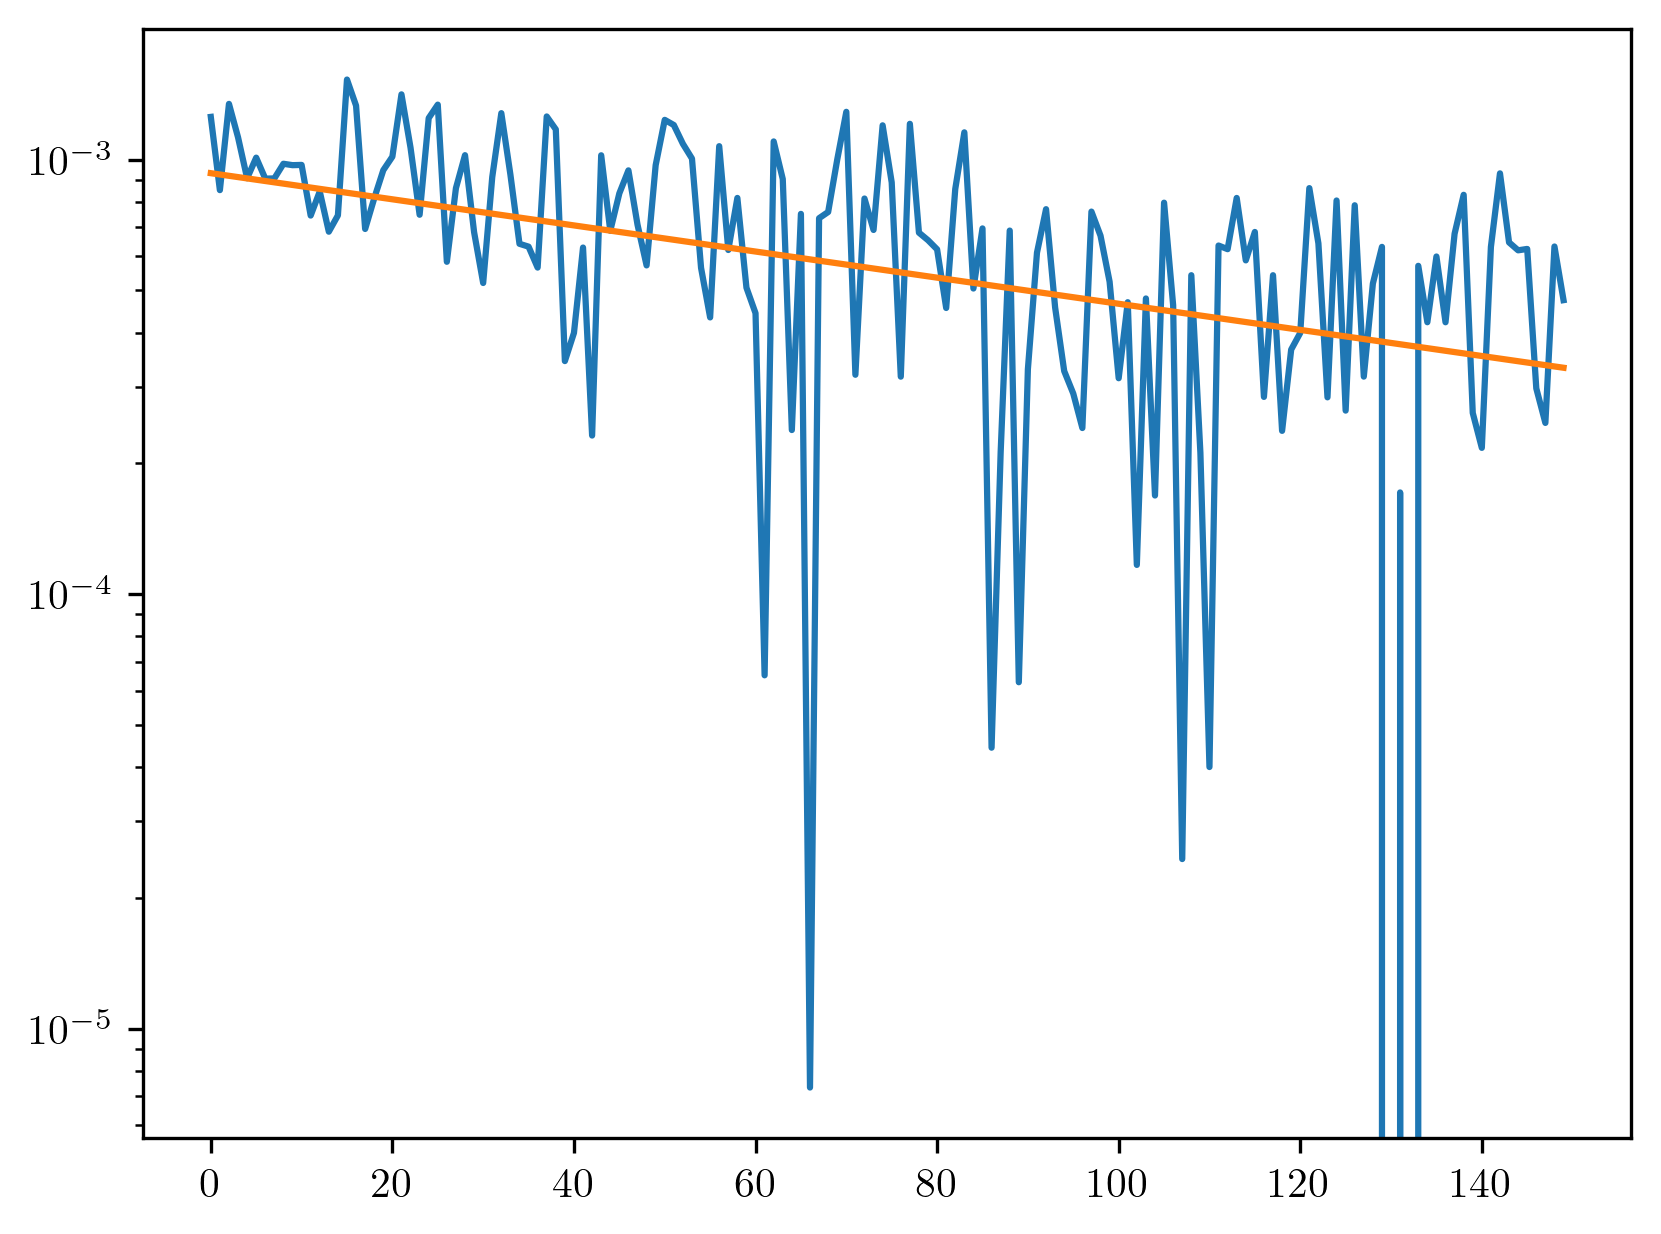

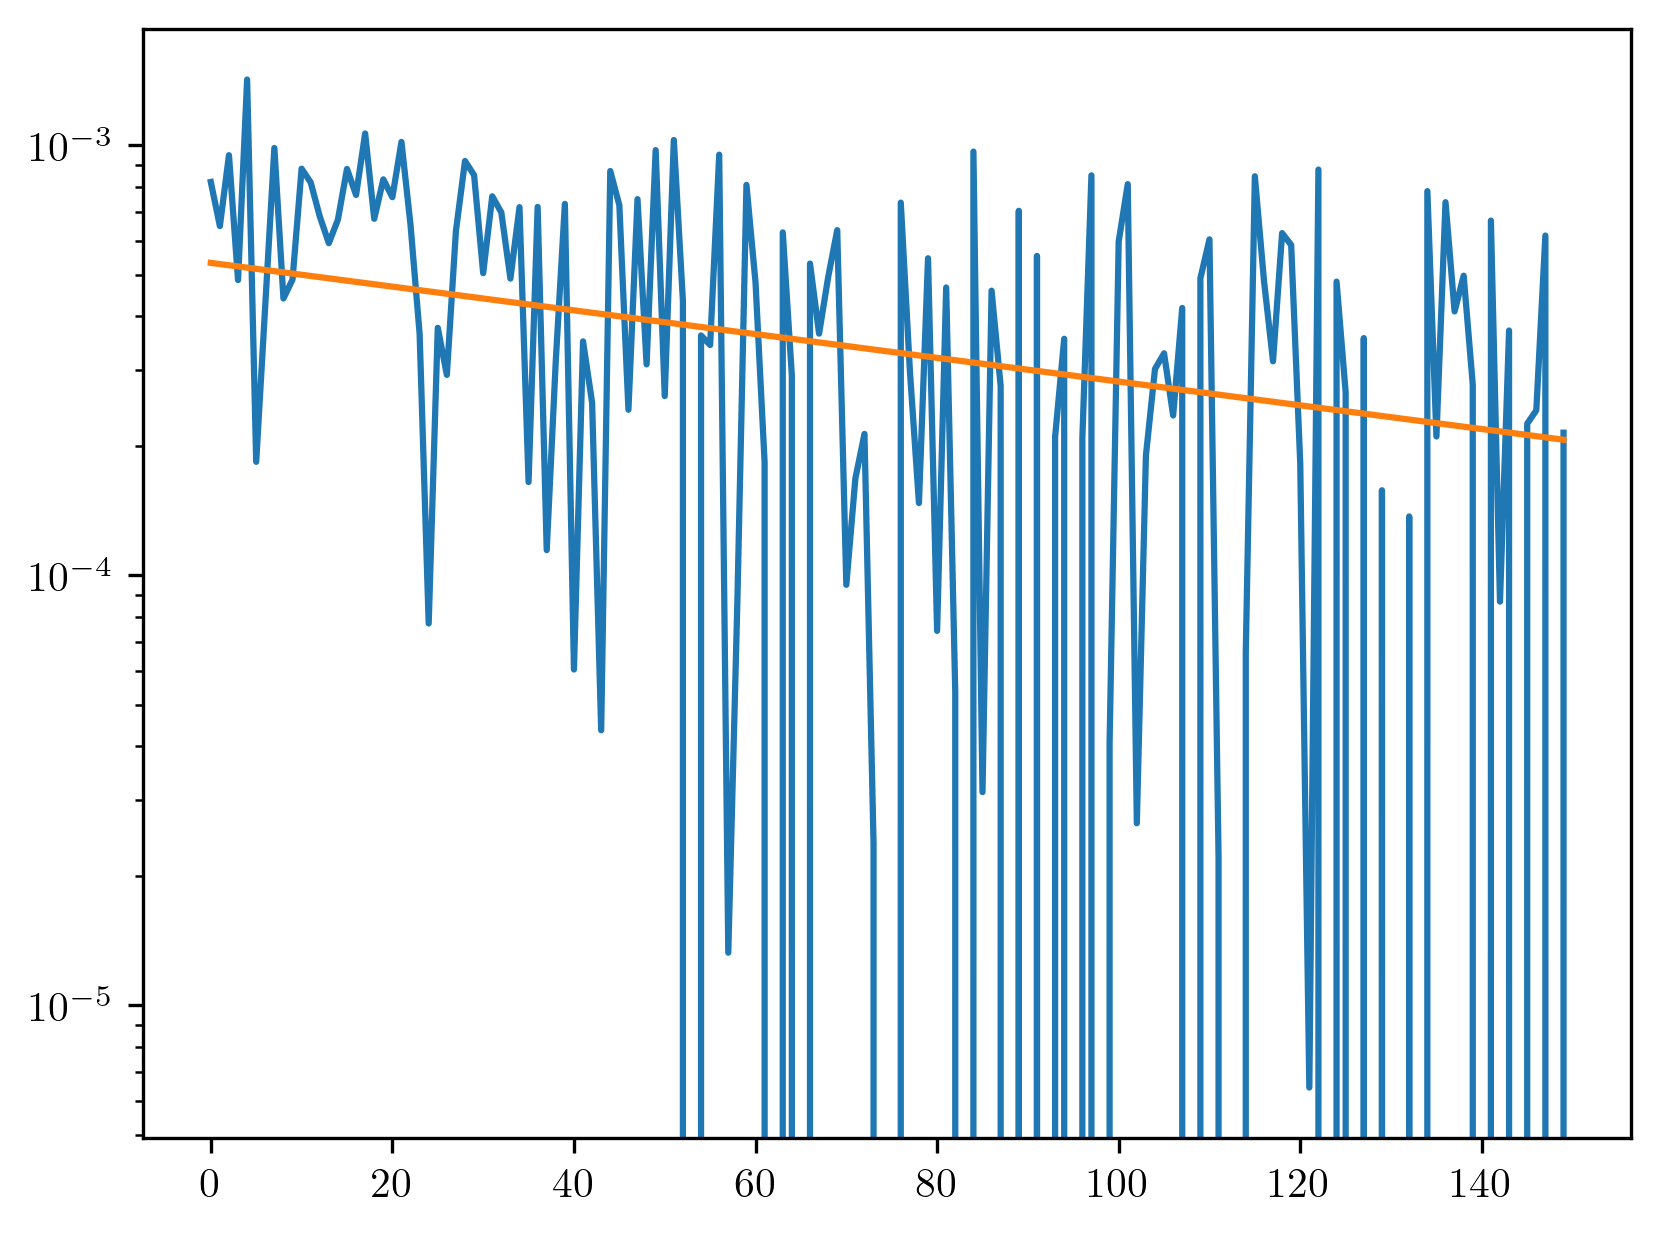

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID5_99dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 100
dtinit=0.001
dxfrac=1/5

lambdasinnm = [402,673,986,1545]

KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(showplots=True) # just to plot full pulses
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=250,end=400,showplots=True) # actually calculate tauqp*

In [3]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls) # use the same linear decay rate for all wavelengths

105.50476052205497 11.169822906915037
0.00947824529482684
117.26334579216123 14.482332575987604
0.008527813983513743
144.52446643638694 29.18717021519952
0.006919243673112983
157.36671230042515 49.05837026625262
0.006354584050093918


In [4]:
def prep_data(offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(offset,offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,eta,sigma1,sigma2,sigma3,sigma4,tau,Q0):
    print('eta (-):\t',eta)
    print('sigma1 (um):\t',sigma1)
    print('sigma2 (um):\t',sigma2)
    print('sigma3 (um):\t',sigma3)
    print('sigma4 (um):\t',sigma4)
    print('tau (us):\t',tau)
    print('Q0 (um-1):\t',Q0)
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm,sigma in zip(lambdasinnm,[sigma1,sigma2,sigma3,sigma4]))
    return np.concatenate(datalist)

def par_func_plot(params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return SIM

def plotsim(eta,sigma1,sigma2,sigma3,sigma4,tau,Q0):
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(par_func_plot)(KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm,sigma in zip(lambdasinnm,[sigma1,sigma2,sigma3,sigma4]))
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [5]:
'''xfit,yfit=prep_data(-5) #e.g. -5 means take 5 data points before the max into account for the data
p0 = [ 0.98814218132266
,	 14.121952856710683
, 12.142725678892138
,	 4.316138435062298
, 0.26004673454240906
,	 0.2833784919537387
, 1.0416224575485475]
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=p0,bounds=[[0.01,0.2,0.2,0.2,0.2,0.01,0.1],[1,length/6,length/6,length/6,length/6,10,np.inf]]) #with tau'''
print('\nDone!')


Done!


In [6]:
'''# Display parameters, standard deviation, and correlation coefficient
parameters = ['eta','sigma1','sigma2','sigma3','sigma4','tau','Q0']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")'''

'# Display parameters, standard deviation, and correlation coefficient\nparameters = [\'eta\',\'sigma1\',\'sigma2\',\'sigma3\',\'sigma4\',\'tau\',\'Q0\']\nprint("Parameters:")\nfor name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):\n    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")\n\nprint("\nCorrelation Coefficients:")\nfor i in range(len(popt)):\n    for j in range(i+1, len(popt)):\n        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")'

In [8]:
'''
Parameters:
eta:	0.9902323471	+/-	0.0614278457
sigma1:	14.8857532731	+/-	3.3475331831
sigma2:	12.1441888471	+/-	1.5196733493
sigma3:	4.1674087500	+/-	1.9763802995
sigma4:	0.8203387900	+/-	4.7311781748
tau:	0.2833774916	+/-	0.0016169463
Q0:	1.0437345269	+/-	0.1114334931

Correlation Coefficients:
eta vs sigma1: -0.5163487838
eta vs sigma2: 0.2490667773
eta vs sigma3: -0.3529697406
eta vs sigma4: -0.3165810235
eta vs tau: 0.4724004563
eta vs Q0: 0.2297861523
sigma1 vs sigma2: 0.5633148066
sigma1 vs sigma3: 0.6138320632
sigma1 vs sigma4: 0.4843770635
sigma1 vs tau: -0.5168318200
sigma1 vs Q0: -0.8194175017
sigma2 vs sigma3: 0.4883734376
sigma2 vs sigma4: 0.3488355571
sigma2 vs tau: -0.3426252696
sigma2 vs Q0: -0.8771386545
sigma3 vs sigma4: 0.3788546838
sigma3 vs tau: -0.3961235050
sigma3 vs Q0: -0.6644039600
sigma4 vs tau: -0.3146548806
sigma4 vs Q0: -0.5065190649
tau vs Q0: 0.4719892552
'''

simdata = plotsim(0.9902323471,
14.8857532731,
12.1441888471,
4.1674087500,
0.8203387900,
0.2833774916,
1.0437345269)

Iteration: 2398	Simtime (us): 100.10242937346953
max Teff =  0.16756532213509157
Iteration: 2487	Simtime (us): 100.12789114114142
max Teff =  0.17202286639646627
Iteration: 2705	Simtime (us): 100.13057284302702
max Teff =  0.17496402712232348
Iteration: 2869	Simtime (us): 100.04520579070758
max Teff =  0.17983112351090808


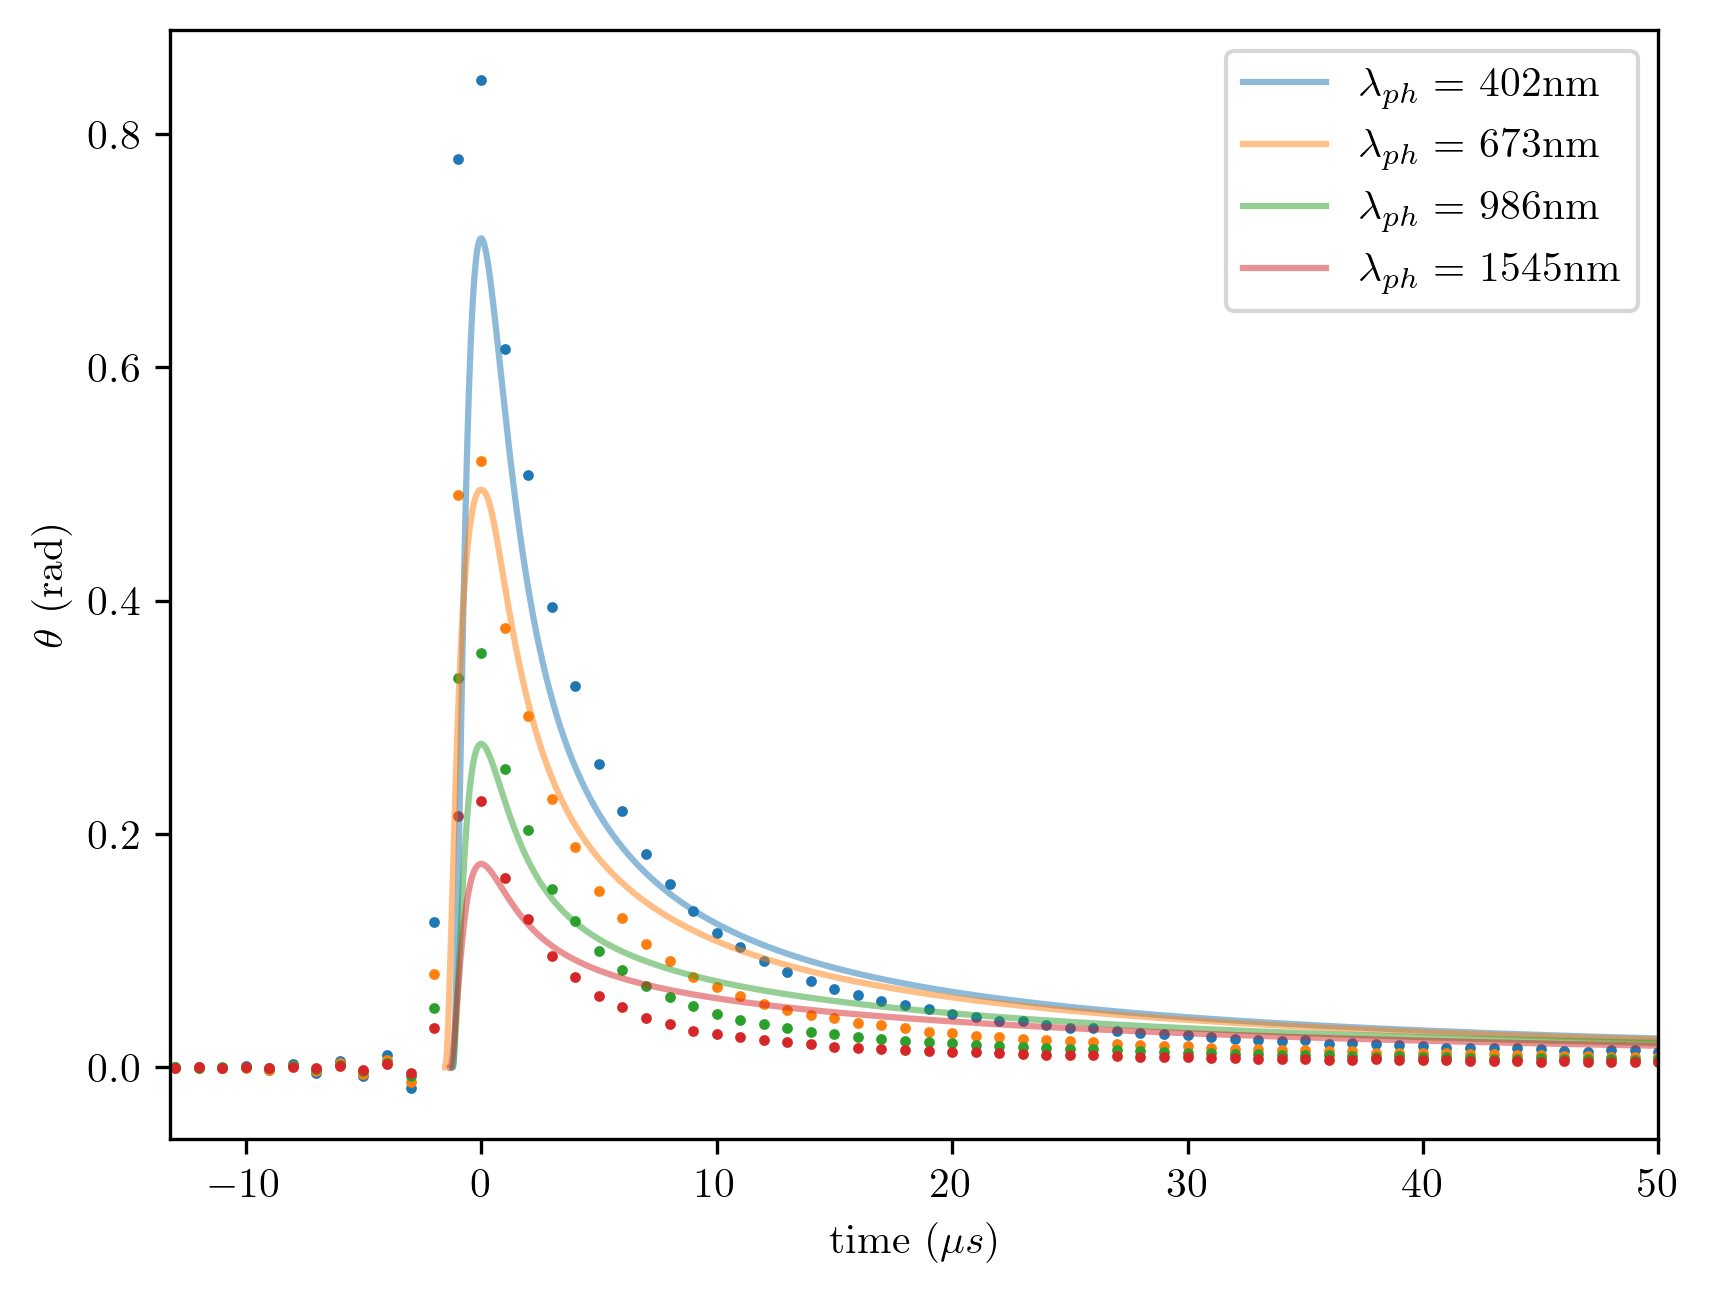

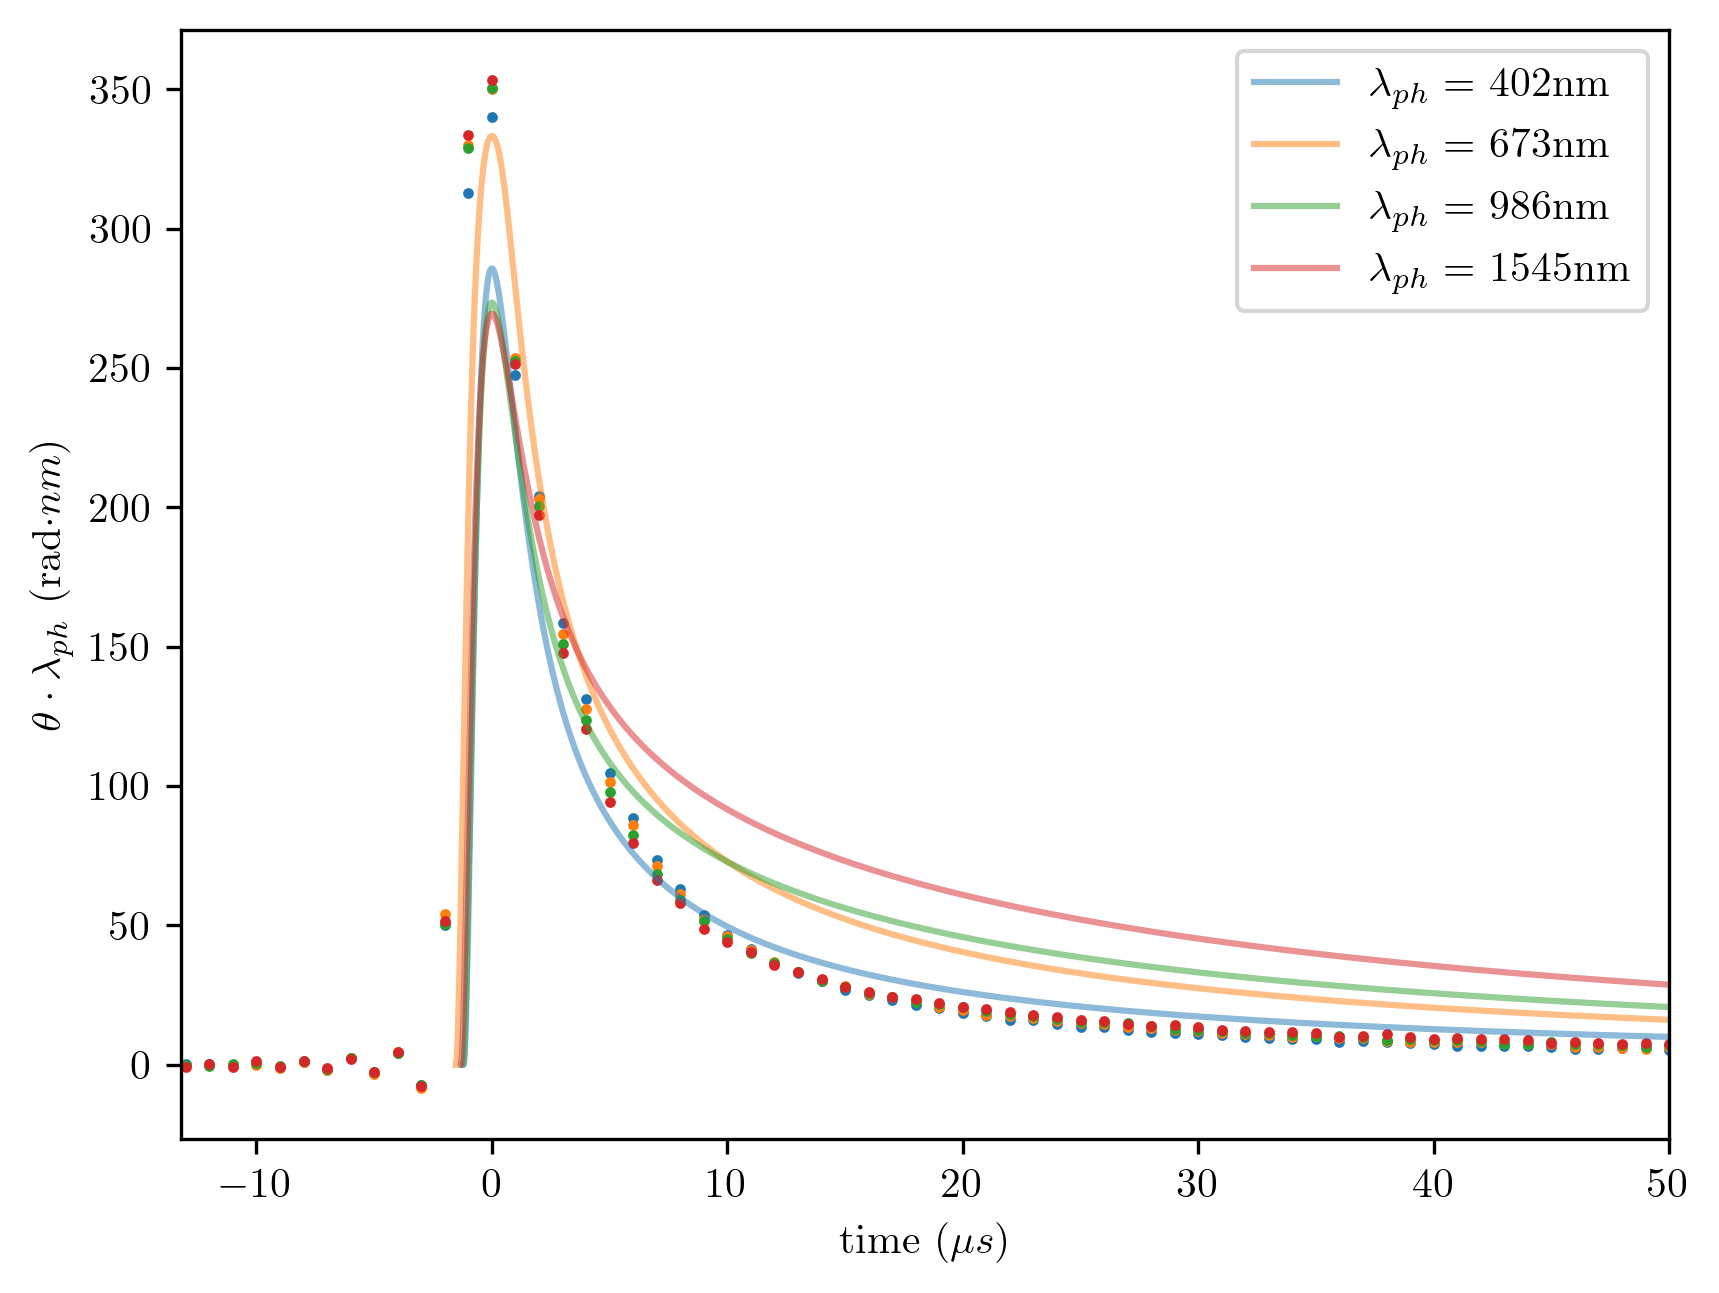

In [9]:
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime,alpha=0.5,label=r'$\lambda_{ph}=$\ '+str(lambdanm)+r'nm')
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta$ (rad)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.legend()
plt.show()
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime*lambdanm,alpha=0.5,label=r'$\lambda_{ph}=$\ '+str(lambdanm)+r'nm')
    plt.scatter(t,phase*lambdanm,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta\cdot\lambda_{ph}$ (rad$\cdot nm$)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.legend()
plt.show()

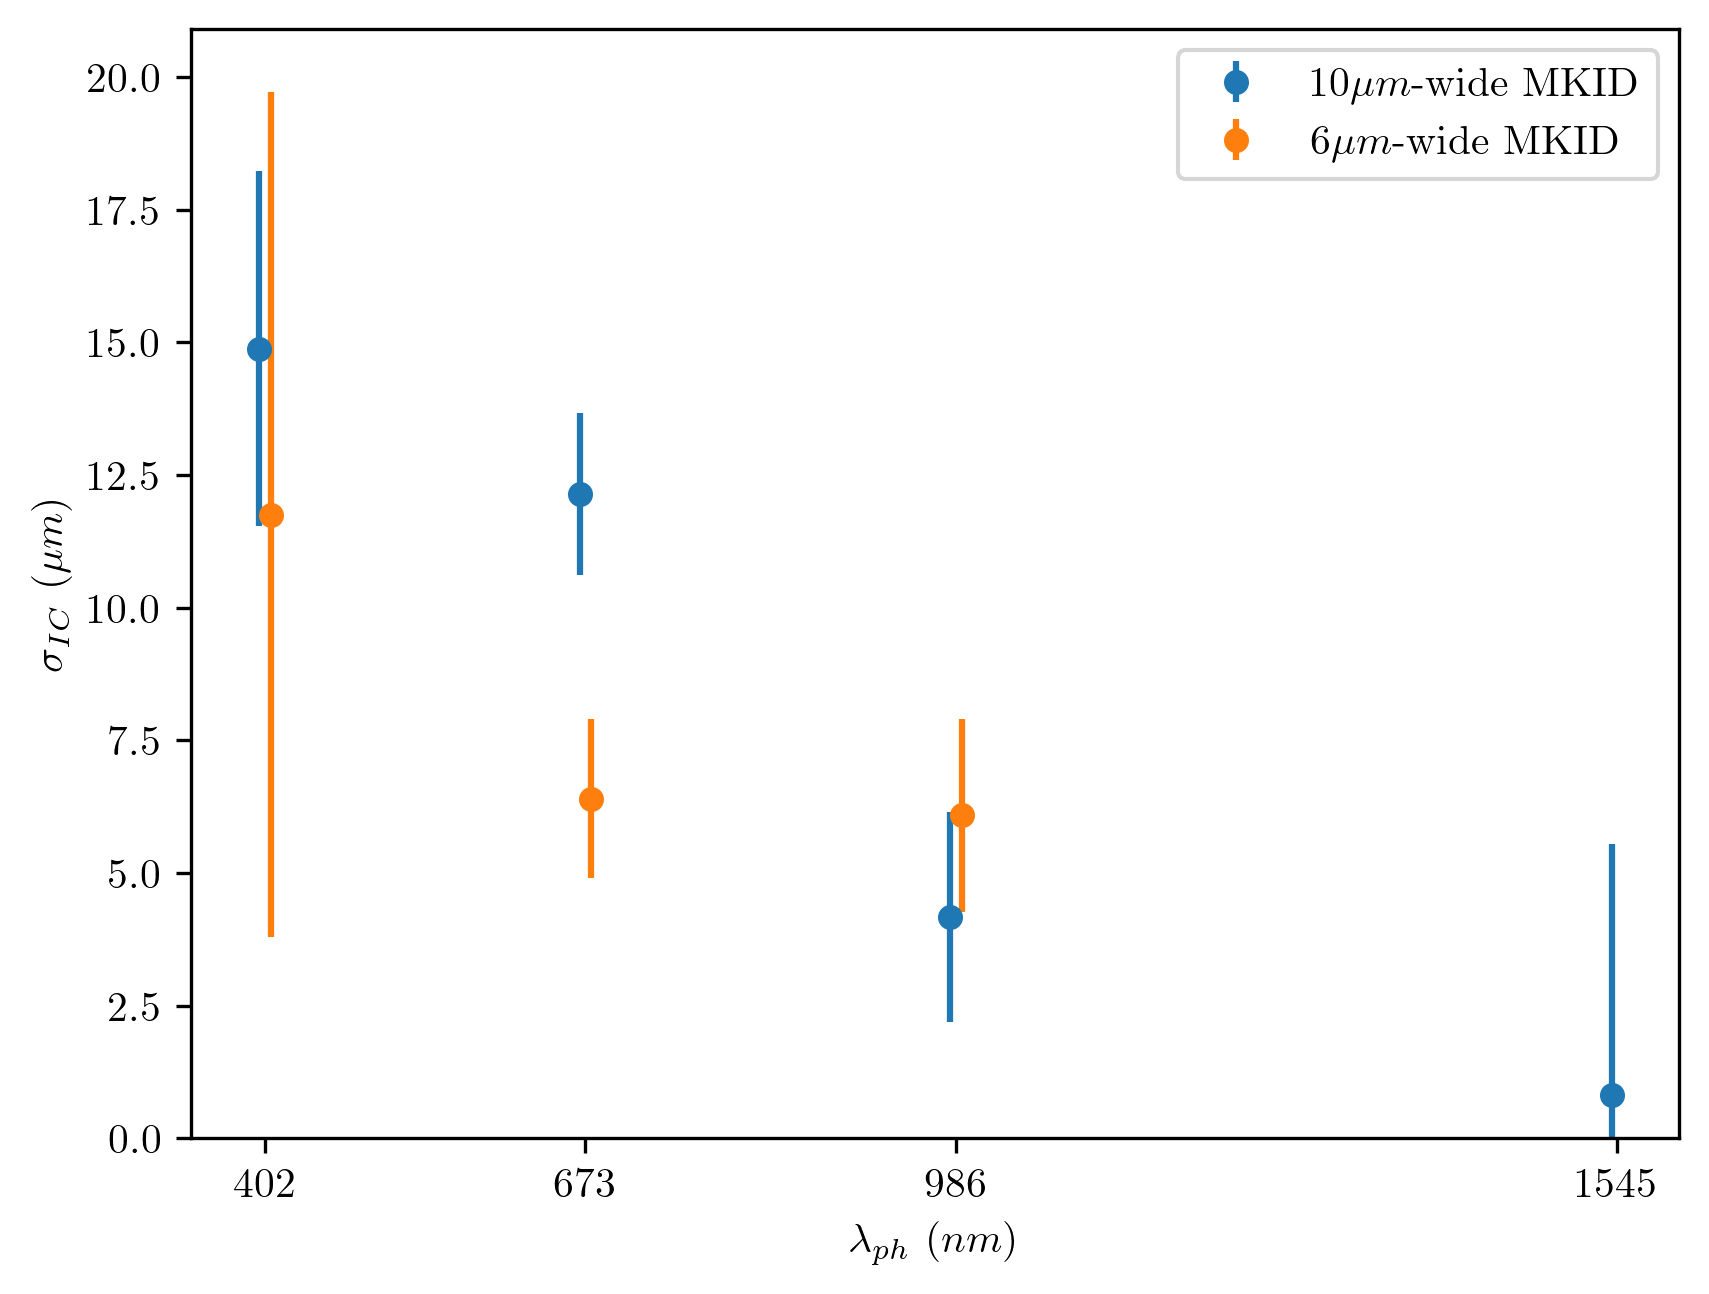

In [10]:
lambdaarray = np.array(lambdasinnm)

sigma10 = [14.8857532731,12.1441888471,4.1674087500,0.8203387900]
sigmasigma10 = [3.3475331831,1.5196733493,1.9763802995,4.7311781748]

sigma6 = [11.7517764996,6.3993243092,6.0862379608,np.nan]
sigmasigma6 = [7.9669088788,1.5017846306,1.8199553945,np.nan]

plt.figure()
plt.errorbar(lambdaarray-5,sigma10,sigmasigma10,label=r'$10\mu m$-wide MKID',linestyle='',marker='.',markersize=10)
plt.errorbar(lambdaarray+5,sigma6,sigmasigma6,label=r'$6\mu m$-wide MKID',linestyle='',marker='.',markersize=10)
plt.legend()
plt.xlabel(r'$\lambda_{ph}$ ($nm$)')
plt.ylabel(r'$\sigma_{IC}$ ($\mu m$)')
plt.xticks(lambdaarray,minor=False)
plt.ylim(0)
plt.show()